## RL Project
This Jupyter notebook is a base for importing the [Arcade Learning Environment](https://ale.farama.org/getting-started/#) (ALE) which is part of the [Gymnasium](https://gymnasium.farama.org) project. ALE can be used to create an environment for various Atari 2600 games for training reinforcement learning models.


In [1]:
!pip install ale-py
!pip install "gymnasium[other]"
# !pip install --user --upgrade git+http://github.com/pyglet/pyglet@pyglet-1.5-maintenance

## Import the native ALE interface as ale_py
Taken from <https://ale.farama.org/getting-started/>

In [1]:
from ale_py import ALEInterface
ale = ALEInterface()

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [148]:
class ReplayMemory:
    """ Stores the replay buffer referred to as D in the pseudo-code """

    def __init__(self, envs, max_size = 1000000, start_size = 50000, frame_height = 84, frame_width = 84, agent_history_length = 4):
        self.max_size = max_size
        self.count = 0
        self.max_count = 0
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        
        self.actions = np.empty(self.max_size, dtype=np.int32)
        self.frames = np.empty((self.max_size, agent_history_length, self.frame_height, self.frame_width), dtype=np.uint8)
        self.rewards = np.empty(self.max_size, dtype=np.float32)
        self.terminations = np.empty(self.max_size, dtype=np.bool)
        
        # We initialise the ReplayMemory with some initial samples
        for _ in range(start_size):
            # Take random actions in all environments
            actions = envs.action_space.sample()
            step_data = envs.step(actions)
            self.add_step_data(actions, step_data)

    def add_step_data(self, actions, step_data):
        
        observations, rewards, terminations, truncations, infos = step_data

        # We're using the vector based Atari environment but only initialising 1 instance so take the first element of each variable
        # print(f"adding count {self.count} action {actions[0]} observations {observations[0].shape} rewards {rewards[0]} terminations {terminations[0]}")
        self.actions[self.count] = actions[0]
        self.frames[self.count] = observations[0]
        self.rewards[self.count] = rewards[0]
        self.terminations[self.count] = terminations[0]
        self.count += 1 
        self.count = self.count % self.max_size
        self.max_count = max(self.max_count, self.count)
        
    def get_random_minibatch(self):
        print("hello")


In [149]:
# List of hyperparameters and their values from Mnih 2015
minibatch_size          = 32          # Number of training cases over which each SGD update is computed.
replay_memory_size      = 1000000     # SGD udpates are sampled from this number of most recent frames.
agent_history_length    = 4           # The number of most recent frames that are given to the Q‑network.
target_update_freq      = 10000       # The frequency with which the target network is updated.
discount_factor         = 0.99        # Discount factor γ used in Q‑learning update.
action_repeat           = 4           # Repeat each selected action this many times.
update_frequency        = 4           # The number of actions selected by the agent between SGD updates.
learning_rate           = 2.5e-4      # The learning rate used by RMSProp.
gradient_momentum       = 0.95        # Gradient momentum used by RMSProp.
squared_grad_momentum   = 0.95        # Squared‑gradient (denominator) momentum used by RMSProp.
min_squared_gradient    = 0.01        # Constant added to squared gradient in the denominator of the RMSProp update.
initial_exploration     = 1.0         # Initial ε in ε‑greedy exploration.
final_exploration       = 0.1         # Final value of ε in ε‑greedy exploration.
final_exploration_frame = 1000000     # Number of frames over which the initial value of ε is linearly annealed to its final value. 1,000,000 in Mnih
replay_start_size       = 50000       # A uniform random policy is run for this number of frames before learning starts and is used to populate the replay memory. 50,000 in Mnih.
noop_max                = 30          # Max number of "do nothing" actions performed by the agent at the start of an episode.

frame_height            = 84
frame_width             = 84


In [157]:
import numpy as np
import random

from ale_py.vector_env import AtariVectorEnv

# *** TODO REMOVE THESE LINES ONCE TESTED
replay_memory_size      = 100
replay_start_size       = 80

def initialise_vector_environment():
    """ Initialises the environment """ 
        
    # Create a vector environment with a single instance of Breakout, the vector environment provides a number of convenient parameters:
    envs = AtariVectorEnv(
        game="pong",  # The ROM id not name, i.e., camel case compared to `gymnasium.make` name versions
        num_envs = 1,                     # The number of parallel environments (we just use 1)
        grayscale = True,                 # Reduce memory by converting to grayscale (from Mnih 2015)
        reward_clipping = True,           # Restricting the rewards to -1, 0 or +1 (as per Mnih 2015)
        stack_num = agent_history_length, # Number of frames to stack (as per Mnih 2015)
        img_height = frame_height,        # Height to resize frames to (as per Mnih 2015)
        img_width = frame_width,          # Width to resize frames to (as per Mnih 2015)
    )

    observations, info = envs.reset(seed=42)

    # Atari games are deterministic. Press fire a random umber of times to prevent the agent simply learning a single ideal path.
    FIRE = 1
    action = np.array([FIRE], dtype=np.int32)
    n = random.randint(0, noop_max)
    print(f"Pressing fire {n} times")
    for _ in range(n):
        step_data = envs.step(action)

    return envs

envs = initialise_vector_environment()


# *** Based on pseudo code for Deep Q-learning with Experience Replay (from the course notes) ***

# Initialise replay memory 𝐷 to capacity 𝑁

# Reset all environments
observations, info = envs.reset(seed=42)

D = ReplayMemory(envs, replay_memory_size, replay_start_size, frame_height, frame_width, agent_history_length)

# Initialise action-value network 𝑞̂1 with parameters 𝜽1 ∈ ℝ𝑑 arbitrarily 

# Initialise target action-value network 𝑞̂2 with parameters 𝜽2 = 𝜽1

num_episodes = 10

# Loop for each episode:
for episode in range(0, num_episodes):

    print(f"epsiode {episode}")
    # Initialise 𝑆

    # Loop for each step of episode:
    while (not terminations[0]) :
    
        # Choose action 𝐴 in state 𝑆 using policy derived from 𝑞̂1(𝑆,⋅,𝜃1) 
        # *** TODO Choose the action accordin to the policy q1 
        #action = envs.action_space.sample()
        FIRE = 1
        action = np.array([FIRE], dtype=np.int32)

        # Take action 𝐴, observe reward 𝑅 and next-state 𝑆′ 
        step_data = envs.step(actions)

        # Store transition (𝑆,𝐴,𝑅,𝑆′) in 𝐷
        D.add_step_data(actions, step_data)
        observations, rewards, terminations, truncations, infos = step_data

        # For each transition (𝑆𝑗,𝐴𝑗,𝑅𝑗,𝑆′𝑗) in minibatch sampled from 𝐷:
            # 𝑦={𝑅𝑗 if 𝑆′𝑗 is terminal, 𝑅𝑗+𝛾max𝑎′𝑞̂2(𝑆′𝑗,𝑎′,𝜽2) otherwise 
            # 𝑦̂=𝑞̂1(𝑆𝑗,𝐴𝑗,𝜽1) 
            # Perform gradient descent step ∇𝜃1𝐿𝛿(𝑦,𝑦̂) 

        if terminations[0] or truncations[0]:
            observation, info = envs.reset()

    # Every 𝐶 time-steps, update 𝜽2=𝜽1

# Close the environment when done
envs.close()


Pressing fire 6 times
epsiode 0
epsiode 1
epsiode 2
epsiode 3
epsiode 4
epsiode 5
epsiode 6
epsiode 7
epsiode 8
epsiode 9


## Inline rendering example

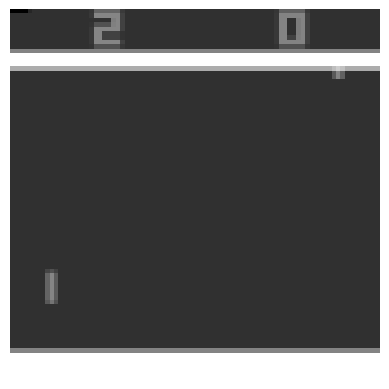

In [140]:
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
%matplotlib inline


# Reset all environments
observations, info = envs.reset()

print(observations.shape)

# Take random actions in all environments
actions = envs.action_space.sample()
observations, rewards, terminations, truncations, infos = envs.step(actions)
for step in range(100):
    # Render the environment  
    for i in range(0, 4):
        img = Image.fromarray(observations[0][i].astype('uint8'))
        #img = img.resize((336, 336), resample=Image.NEAREST)
        plt.imshow(img, cmap='gray')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.axis('off')
    
    # Choose a random action, this is where we would insert a policy
    action = envs.action_space.sample()
    step_data = envs.step(action)
    
    observations, rewards, terminations, truncations, infos = step_data
    
    # If the episode has ended then we can reset to start a new episode
    if terminations[0] or truncations[0]:
        observations, infos = envs.reset()

# Close the environment when done
envs.close()